In [2]:
import tensorflow as tf
import os,re
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

images/DCCB_ZH-CN12497477745_20180309.jpg


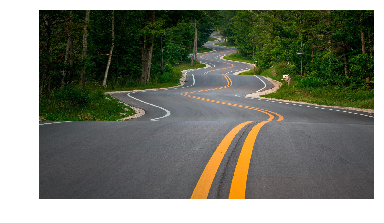

lakeside, lakeshore (score = 37.65447 % )
valley, vale (score = 8.35219 % )
seashore, coast, seacoast, sea-coast (score = 3.70766 % )
alp (score = 2.49016 % )
geyser (score = 1.98095 % )

images/EasternGrey_ZH-CN11969577596_20180126.jpg


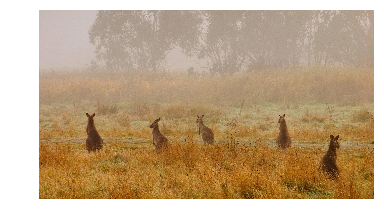

meerkat, mierkat (score = 28.06172 % )
mongoose (score = 21.15067 % )
wallaby, brush kangaroo (score = 19.33113 % )
Windsor tie (score = 4.99894 % )
hyena, hyaena (score = 3.22489 % )

images/HawaMahal_ZH-CN7259847753_20180329.jpg


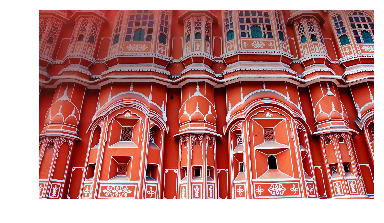

palace (score = 63.47876 % )
organ, pipe organ (score = 8.57255 % )
church, church building (score = 7.04828 % )
castle (score = 4.04237 % )
cinema, movie theater, movie theatre, movie house, picture palace (score = 1.57862 % )

images/HighlandCattle_ZH-CN6977858757_20180115.jpg


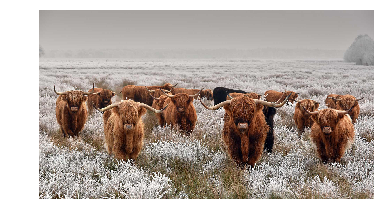

ox (score = 89.39719 % )
water buffalo, water ox, Asiatic buffalo, Bubalus bubalis (score = 2.07509 % )
oxcart (score = 1.99804 % )
lakeside, lakeshore (score = 0.31921 % )
bison (score = 0.28019 % )

images/LionFish_ZH-CN6318723202_20180116.jpg


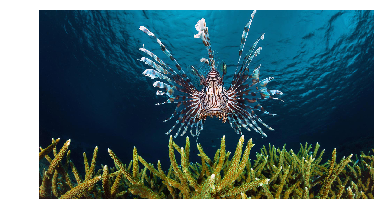

lionfish (score = 95.60347 % )
coral reef (score = 0.28063 % )
sea urchin (score = 0.11253 % )
spiny lobster, langouste, rock lobster, crawfish, crayfish, sea crawfish (score = 0.07745 % )
scuba diver (score = 0.03996 % )

images/MudstoneBadlands_ZH-CN9863836503_20171110.jpg


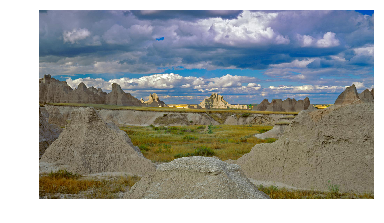

castle (score = 93.51983 % )
palace (score = 1.21963 % )
stupa, tope (score = 0.32357 % )
promontory, headland, head, foreland (score = 0.31440 % )
monastery (score = 0.27123 % )



In [24]:
class NodeLookup(object):
    def __init__(self):
        label_lookup_path = 'inception_model/imagenet_2012_challenge_label_map_proto.pbtxt'
        uid_lookup_path = 'inception_model/imagenet_synset_to_human_label_map.txt'
        self.node_lookup = self.load(label_lookup_path,uid_lookup_path)
    def load(self,label_lookup_path,uid_lookup_path):
#         加载分类字符串 对应分类名称的文件
        proto_as_ascii_lines = tf.gfile.GFile(uid_lookup_path).readlines()
        uid_to_human = {}
#     按行读取数据
        for line in proto_as_ascii_lines:
            parsed_items = line.strip('\n').split('\t')
            uid = parsed_items[0]
            human_string = parsed_items[1]
#             保存编号字符串与分类名称的对应关系
            uid_to_human[uid] = human_string
    
#       加载分类字符串 对应分类编号1-1000的文件
        proto_as_ascii = tf.gfile.GFile(label_lookup_path).readlines()
        node_id_to_uid = {}
        for line in proto_as_ascii:
    #         保存分类编号1-1000与编号字符串的映射关系
            if line.startswith('  target_class:'):
                target_class = int(line.split(':')[1])
            if line.startswith('  target_class_string:'):
                target_class_string = line.split(':')[1]
#                 字符串提取' "n01440764"'
                node_id_to_uid[target_class] = target_class_string[2:-2]

    #     建立分类编号1-1000对应分类名称的映射关系
        node_id_to_name = {}
        for key,val in node_id_to_uid.items():
            name = uid_to_human[val]
            node_id_to_name[key] = name
        return node_id_to_name
    
    def id_to_string(self,node_id):
        if node_id not in self.node_lookup:
            return ''
        return self.node_lookup[node_id]

# 创建一个图来存放google训练好的模型
with tf.gfile.FastGFile('inception_model/classify_image_graph_def.pb','rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
    tf.import_graph_def(graph_def,name='')
    
with tf.Session() as sess:
    softmax_tensor = sess.graph.get_tensor_by_name('softmax:0')
#     遍历目录
    for root,dirs,files in os.walk('images/'):
        for file in files:
#             载入图片
            image_data = tf.gfile.FastGFile(os.path.join(root,file),'rb').read()
#             图片是jpg格式，并转化为一维数据
            predictions = sess.run(softmax_tensor,{'DecodeJpeg/contents:0':image_data})
            predictions = np.squeeze(predictions)
        
            image_path = os.path.join(root,file)
            print(image_path)
            
#             显示图片
            img = Image.open(image_path)
            plt.imshow(img)
            plt.axis('off')
            plt.show()
            
#             排序,选择5个值，从大到小排序
            top_k = predictions.argsort()[-5:][::-1]
            
            node_lookup = NodeLookup()
            for node_id in top_k:
#                 获取分类名称及置信度
                human_string = node_lookup.id_to_string(node_id)
                score = predictions[node_id]
                print("%s (score = %.5f%% )" % (human_string,score*100))
            print()